<a href="https://colab.research.google.com/github/Yunnnnn615/LSTM_pre1day/blob/main/0812.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import yfinance as yf
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
start = dt.datetime(2020,1,1)
end = dt.datetime.now()
from google.colab import files

plt.style.use('ggplot')
# pd.set_option('display.max_rows', None) #顯示所有row

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Import Future Data


In [3]:
df = pd.read_csv('/content/drive/My Drive/TMBA/0804_data/TXF_1m.csv')

df.index = pd.to_datetime(df['datetime']) #轉為Timeseries並設為index
df.sort_index(inplace=True)
df = df.drop(columns=['Time', 'datetime', 'Unnamed: 0'])
df.columns = ['open', 'high', 'low', 'close', 'volume', 'Date']
df['Hour'] = df.index.hour #讀取time小時的部分
df.head(3)

,open,high,low,close,volume,Date,Hour
datetime,,,,,,,
2010-01-04 08:46:00,8203.0,8208.0,8184.0,8187.0,1108,2010-01-04,8
2010-01-04 08:47:00,8187.0,8195.0,8186.0,8193.0,429,2010-01-04,8
2010-01-04 08:48:00,8194.0,8201.0,8193.0,8200.0,419,2010-01-04,8


In [4]:
rule = '60T'

Morning = df[(df['Hour'] >= 8) & (df['Hour'] <= 13)]
Morning.index = Morning.index + dt.timedelta(minutes=15)

d1 = Morning.resample(rule=rule, closed='right', label='left').first()[['open']]
d2 = Morning.resample(rule=rule, closed='right', label='left').max()[['high']]
d3 = Morning.resample(rule=rule, closed='right', label='left').min()[['low']]
d4 = Morning.resample(rule=rule, closed='right', label='left').last()[['close']]
d5 = Morning.resample(rule=rule, closed='right', label='left').sum()[['volume']]
d6 = Morning.resample(rule=rule, closed='right', label='left').last()[['Date']]


df_Morning = pd.concat([d1,d2,d3,d4,d5,d6], axis=1)
df_Morning = df_Morning.dropna()
df_Morning.index = df_Morning.index - dt.timedelta(minutes=15)

In [5]:
df_Morning

,open,high,low,close,volume,Date
datetime,,,,,,
2010-01-04 08:45:00,8203.0,8211.0,8181.0,8187.0,17247,2010-01-04
2010-01-04 09:45:00,8187.0,8188.0,8101.0,8165.0,31531,2010-01-04
2010-01-04 10:45:00,8167.0,8180.0,8158.0,8172.0,8859,2010-01-04
2010-01-04 11:45:00,8172.0,8207.0,8167.0,8197.0,12329,2010-01-04
2010-01-04 12:45:00,8198.0,8200.0,8165.0,8166.0,13915,2010-01-04
...,...,...,...,...,...,...
2024-07-12 08:45:00,24038.0,24070.0,23880.0,23920.0,38473,2024-07-12
2024-07-12 09:45:00,23921.0,23979.0,23811.0,23944.0,29848,2024-07-12
2024-07-12 10:45:00,23943.0,23960.0,23863.0,23878.0,10436,2024-07-12


In [25]:
df_Morning = df_Morning[(df_Morning.index >= '2010-01-01 00:00:00') ].copy()

##Import fundamental data

In [26]:
df_light = pd.read_excel('/content/drive/My Drive/TMBA/0804_data/tw_light.xlsx')
df_m1 = pd.read_excel('/content/drive/My Drive/TMBA/0804_data/M1_AB.xlsx')
df_vix= yf.download('^VIX',start,end)
df_m1.head(3)

[*********************100%***********************]  1 of 1 completed


,Date,貨幣總計數-M1A,貨幣總計數-M1B
0,2010-01-01,3869862,10507106
1,2010-02-01,3990178,10628208
2,2010-03-01,3854475,10512754


In [27]:
df_light['Date']=pd.to_datetime(df_light['Date'])
df_m1['Date']=pd.to_datetime(df_m1['Date'])
df_Morning['Date']=pd.to_datetime(df_Morning['Date'],format='ISO8601')
df_vix.index=pd.to_datetime(df_vix.index)

In [28]:
def add_factor(df, df_factor, factor_name):
  list1=[]
  k=0
  for i in range(len(df)):
    if k==len(df_factor):
      list1.append(df_factor[factor_name][k-1])
    else:
      if df['Date'][i]<=df_factor['Date'][k]:
        list1.append(df_factor[factor_name][k])
      else:
        k+=1
        if k==len(df_factor):
          list1.append(df_factor[factor_name][k-1])
        else:
          list1.append(df_factor[factor_name][k])
  df[factor_name]=list1
  return df

In [29]:
df_vix['Date']=df_vix.index
df_vix = df_vix.rename(columns={'Adj Close': 'vix_CBOE'})

In [30]:
data=add_factor(df_Morning.copy(), df_light, '景氣對策信號(分)')
data=add_factor(data, df_light, '領先指標不含趨勢指數(點)')
data=add_factor(data, df_m1, '貨幣總計數-M1A')
data=add_factor(data, df_m1, '貨幣總計數-M1B')
data=add_factor(data, df_vix, 'vix_CBOE')
data

<ipython-input-28-2f78aeb7e4bd>:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if df['Date'][i]<=df_factor['Date'][k]:
<ipython-input-28-2f78aeb7e4bd>:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if df['Date'][i]<=df_factor['Date'][k]:
<ipython-input-28-2f78aeb7e4bd>:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if df['Date'][i]<=df_factor['Date'][k]:
<ipython-input-28-2f78aeb7e4bd>:8: FutureWarning: Series.__getitem__ trea

,open,high,low,close,volume,Date,景氣對策信號(分),領先指標不含趨勢指數(點),貨幣總計數-M1A,貨幣總計數-M1B,vix_CBOE
datetime,,,,,,,,,,,
2010-01-04 08:45:00,8203.0,8211.0,8181.0,8187.0,17247,2010-01-04,38,106.47,3990178,10628208,12.47
2010-01-04 09:45:00,8187.0,8188.0,8101.0,8165.0,31531,2010-01-04,38,106.47,3990178,10628208,12.47
2010-01-04 10:45:00,8167.0,8180.0,8158.0,8172.0,8859,2010-01-04,38,106.47,3990178,10628208,12.47
2010-01-04 11:45:00,8172.0,8207.0,8167.0,8197.0,12329,2010-01-04,38,106.47,3990178,10628208,12.47
2010-01-04 12:45:00,8198.0,8200.0,8165.0,8166.0,13915,2010-01-04,38,106.47,3990178,10628208,12.47
...,...,...,...,...,...,...,...,...,...,...,...
2024-07-12 08:45:00,24038.0,24070.0,23880.0,23920.0,38473,2024-07-12,38,103.59,11086939,27436734,12.46
2024-07-12 09:45:00,23921.0,23979.0,23811.0,23944.0,29848,2024-07-12,38,103.59,11086939,27436734,12.46
2024-07-12 10:45:00,23943.0,23960.0,23863.0,23878.0,10436,2024-07-12,38,103.59,11086939,27436734,12.46


##Settlement Data

In [31]:
file_path ='/content/drive/My Drive/TMBA/0804_data/settlementDate.csv'
settlementDate_ = pd.read_csv(file_path)
settlementDate_.columns = ['settlementDate', 'futures', 'settlementPrice']
settlementDate_

,settlementDate,futures,settlementPrice
0,2024/07/26,202407W4,22069
1,2024/07/17,202407,23680
2,2024/07/10,202407W2,23996
3,2024/07/03,202407W1,23138
4,2024/06/26,202406W4,22965
...,...,...,...
740,1999/01/21,199901,6332
741,1998/12/17,199812,6695
742,1998/11/19,199811,7185
743,1998/10/22,199810,7068


In [32]:
bool_ = [False if 'W' in i else True for i in settlementDate_['futures']]
settlementDate = [i.replace('/','-') for i in list(settlementDate_[bool_]['settlementDate'])]
settlementDate = [pd.to_datetime(i).date() for i in settlementDate]

##Add technical indicators

In [33]:
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3

import talib as ta

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4015    0  4015    0     0  16185      0 --:--:-- --:--:-- --:--:-- 16189
100  517k  100  517k    0     0   851k      0 --:--:-- --:--:-- --:--:--  851k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4091    0  4091    0     0  16024      0 --:--:-- --:--:-- --:--:-- 16043
100  392k  100  392k    0     0   632k      0 --:--:-- --:--:-- --:--:-- 2908k


In [34]:
import numpy as np

# 新增布林帶特徵
#data['BB_upper'], data['BB_middle'], data['BB_lower'] = ta.BBANDS(data['close'], timeperiod=10)

# 新增ATR特徵
data['ATR'] = ta.ATR(data['high'], data['low'], data['close'], timeperiod=14)

# 新增標準差特徵
data['sd'] = data['close'].rolling(window=20).std()

#偏度
data['skewness']=data['close'].rolling(window=20).skew()

#峰度
data['kurtosis']=data['close'].rolling(window=20).kurt()

#成交量變化
data['pct_volumn']=data['volume'].pct_change()

#價格特徵
data['close-open']=(data['close']-data['open'])/data['open']
data['high-low']=(data['high']-data['low'])/data['low']
data['pre_close']=data['close'].shift(1)
data['price_change']=data['close']-data['pre_close']
data['pct_change']=data['close']/data['pre_close']-1

# #移動平均
data['MA5']=data['close'].rolling(window=5).mean()
data['MA10']=data['close'].rolling(window=10).mean()
data['MA15']=data['close'].rolling(window=15).mean()
# data.dropna(inplace=True)

#技術分析
data['RSI']=ta.RSI(data['close'],timeperiod=12)
data['MOM']=ta.MOM(data['close'],timeperiod=5)
data['EMA5']=ta.EMA(data['close'],timeperiod=5)
data['EMA10']=ta.EMA(data['close'],timeperiod=10)
data['EMA26']=ta.EMA(data['close'],timeperiod=26)
data['MACD'],_,_=ta.MACD(data['close'],fastperiod=12,slowperiod=26,signalperiod=9)

data['K'],data['D']=ta.STOCH(data['high'],data['low'],data['close'],fastk_period=9,slowk_period=5,slowk_matype=1,slowd_period=5,slowd_matype=1)

data.loc[:,'J']=3*data.loc[:,'K']-2*data.loc[:,'D']

In [35]:
data = data.drop(columns=['Date','open','high','low'])
data.dropna(inplace=True)
data

,close,volume,景氣對策信號(分),領先指標不含趨勢指數(點),貨幣總計數-M1A,貨幣總計數-M1B,vix_CBOE,ATR,sd,skewness,...,MA15,RSI,MOM,EMA5,EMA10,EMA26,MACD,K,D,J
datetime,,,,,,,,,,,,,,,,,,,,,
2010-01-12 11:45:00,8317.0,13475,38,106.47,3990178,10628208,12.47,47.584201,28.847330,-0.364071,...,8295.333333,57.966384,-16.0,8307.163788,8304.177833,8274.144831,30.802994,59.513866,62.601907,53.337786
2010-01-12 12:45:00,8308.0,13980,38,106.47,3990178,10628208,12.47,45.828186,28.505955,-0.329226,...,8298.600000,55.494976,-13.0,8307.442525,8304.872772,8276.652622,28.764769,58.990553,61.398122,54.175414
2010-01-13 08:45:00,8240.0,29306,38,106.47,3990178,10628208,12.47,48.483316,31.128384,-0.257227,...,8298.600000,41.064276,-52.0,8284.961684,8293.077723,8273.937613,21.415564,43.233285,55.343176,19.013503
2010-01-13 09:45:00,8220.0,26282,38,106.47,3990178,10628208,12.47,47.877365,34.918665,-0.312039,...,8295.266667,37.901961,-65.0,8263.307789,8279.790864,8269.942234,13.818146,33.016451,47.900934,3.247483
2010-01-13 10:45:00,8220.0,21456,38,106.47,3990178,10628208,12.47,46.314696,37.355018,-0.217736,...,8292.400000,37.901961,-81.0,8248.871859,8268.919798,8266.242809,7.708282,27.487157,41.096342,0.268788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-12 08:45:00,23920.0,38473,38,103.59,11086939,27436734,12.46,147.574463,199.769894,1.074189,...,24044.666667,48.111589,-386.0,24172.526990,24135.354941,23915.802841,193.767614,63.704909,78.859005,33.396717
2024-07-12 09:45:00,23944.0,29848,38,103.59,11086939,27436734,12.46,149.033430,198.908991,1.063560,...,24053.066667,49.370991,-384.0,24096.351326,24100.563134,23917.891519,166.206558,49.933463,69.217158,11.366074
2024-07-12 10:45:00,23878.0,10436,38,103.59,11086939,27436734,12.46,145.316756,200.828180,1.078910,...,24054.600000,46.020082,-457.0,24023.567551,24060.097109,23914.936592,137.454089,37.048796,58.494371,-5.842353


##LSTM


In [36]:
def stock_price_LSTM(df, pre_days, mem_days):

  df['prediction']=df['close'].shift(-pre_days)

  from sklearn.preprocessing import StandardScaler
  scaler = StandardScaler()
  scaler_x = scaler.fit_transform(df.iloc[:, :-1])

  from collections import deque
  deq = deque(maxlen=mem_days)
  x=[]
  for i in scaler_x:
    deq.append(list(i))
    if len(deq) == mem_days:
      x.append(list(deq))
  x_lately=x[-pre_days:]
  x=x[:-pre_days]
  y = df['prediction'].values[mem_days-1:-pre_days]

  import numpy as np
  x = np.array(x)
  y = np.array(y)
  return x, y, x_lately

In [37]:
import os
# 確認目錄是否存在，若不存在則創建
save_dir = '/content/drive/My Drive/lstm_models_final/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [38]:
pre_days = 1
# mem_days = [5, 10, 15]
# lstm_layers = [1, 2, 3]
# dense_layers = [1, 2, 3]
# units = [16, 32]
#.weights.h5
#.keras

mem_days = [5]
lstm_layers = [1]
dense_layers = [1]
units = [32]
from tensorflow.keras.callbacks import ModelCheckpoint
for the_mem_days in mem_days:
  for the_lstm_layers in lstm_layers:
    for the_dense_layers in dense_layers:
      for the_units in units:
        model_name = "{val_mape:.2f}_{epoch:02d}_" + f'mem_{the_mem_days}_lstm_{the_lstm_layers}_dense_{the_dense_layers}_units_{the_units}.keras'
        filepath = os.path.join(save_dir, model_name)
        checkpoint= ModelCheckpoint(filepath, monitor='val_mape', verbose=1, save_best_only=True, mode='min', save_weights_only=False)

        x,y, x_lately=stock_price_LSTM(data, pre_days, the_mem_days)
        from sklearn.model_selection import train_test_split
        x_train, x_test, y_train, y_test = train_test_split(x, y,shuffle=False, test_size=0.2)

        import tensorflow as tf
        from tensorflow.keras.models import Sequential
        from tensorflow.keras.layers import Dense, Dropout, LSTM
        model = Sequential()
        model.add(LSTM(the_units, input_shape=x.shape[1:], activation='relu', return_sequences=True))
        model.add(Dropout(0.1))

        #添加 LSTM 層
        for i in range(the_lstm_layers - 1):  # 減少一層以避免多加了一層
            model.add(LSTM(the_units, activation='relu', return_sequences=True))
            model.add(Dropout(0.1))

        # 最後一層 LSTM，return_sequences 設為 False
        model.add(LSTM(the_units, activation='relu', return_sequences=False))
        model.add(Dropout(0.1))

        # 添加 Dense 層
        for i in range(the_dense_layers):
            model.add(Dense(the_units, activation='relu'))
            model.add(Dropout(0.1))

        model.add(Dense(1))
        model.compile(loss='mae',optimizer='adam',metrics=['mape'])
        model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test), callbacks=[checkpoint])

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


500/501 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5968.8906 - mape: 58.0939
Epoch 1: val_mape improved from inf to 6.52429, saving model to /content/drive/My Drive/lstm_models_final/6.52_01_mem_5_lstm_1_dense_1_units_32.keras
501/501 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 5958.7324 - mape: 57.9956 - val_loss: 1206.9399 - val_mape: 6.5243
Epoch 2/50
499/501 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1215.5757 - mape: 11.8915
Epoch 2: val_mape improved from 6.52429 to 5.37534, saving model to /content/drive/My Drive/lstm_models_final/5.38_02_mem_5_lstm_1_dense_1_units_32.keras
501/501 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 1215.1705 - mape: 11.8872 - val_loss: 923.4218 - val_mape: 5.3753
Epoch 3/50
500/501 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1025.4163 - mape: 9.9473
Epoch 3: val_mape improved from 5.37534 to 2.93497, saving model to /content/drive/My Drive/lstm_models_final/2.93_03_mem_5_lstm_1_dense_1_units_32.keras
501/501 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 1025.3152 - 

KeyboardInterrupt: 

In [40]:
from tensorflow.keras.models import load_model
best_model =load_model('/content/drive/My Drive/lstm_models_final/0.84_23_mem_5_lstm_1_dense_1_units_32.keras')

In [41]:
best_model.evaluate(x_test, y_test)
pre = best_model.predict(x_test)

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 150.5222 - mape: 0.9237
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step


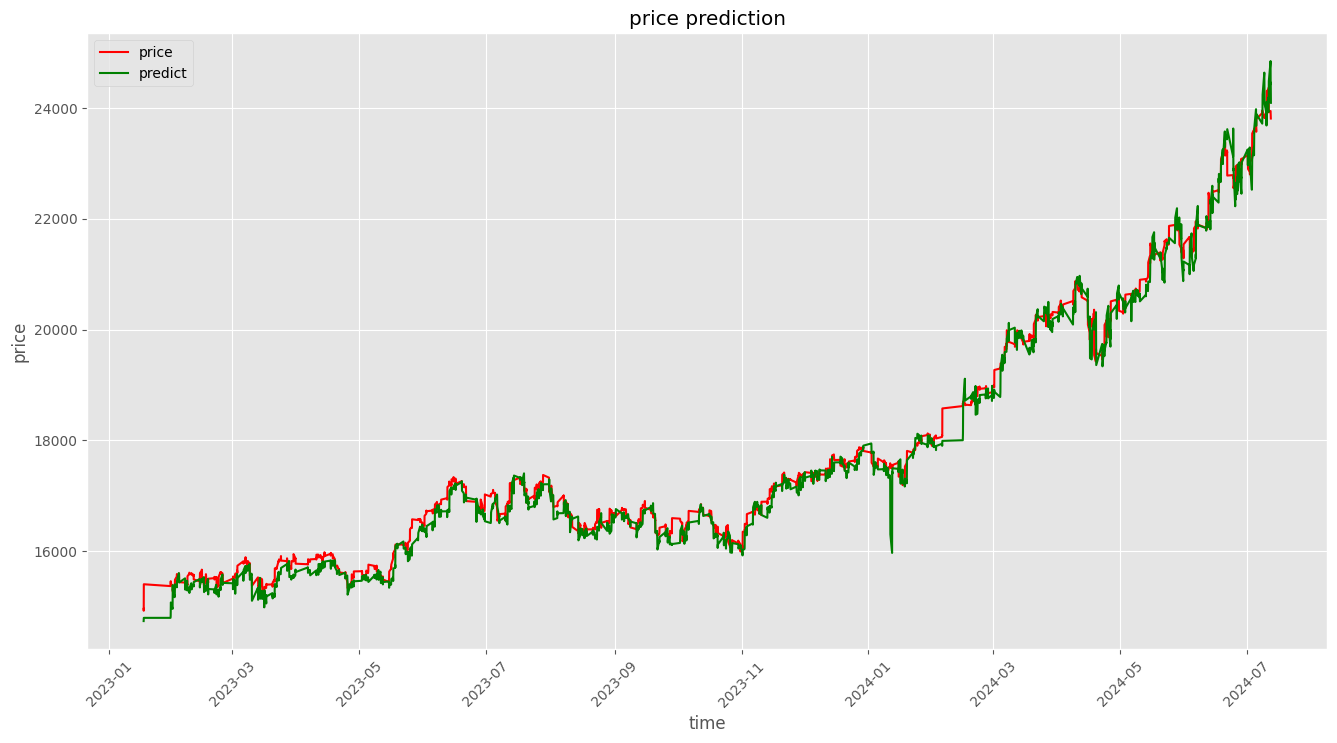

In [56]:
import matplotlib.pyplot as plt
# Convert y_test to a Pandas Series
y_test = pd.Series(y_test)
# 將 y_test 往後移動一天
y_test_shifted = y_test.shift(-1)

# 將 data_time 往後減少一天
data_time_shifted = data.index[-len(y_test_shifted):]

plt.figure(figsize=(16, 8))
plt.plot(data_time_shifted,  y_test_shifted, color='red', label='price')
plt.plot(data_time_shifted, pre, color='green', label='predict')
plt.title('price prediction')
plt.xlabel('time')
plt.ylabel('price')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [50]:
data

,close,volume,景氣對策信號(分),領先指標不含趨勢指數(點),貨幣總計數-M1A,貨幣總計數-M1B,vix_CBOE,ATR,sd,skewness,...,RSI,MOM,EMA5,EMA10,EMA26,MACD,K,D,J,prediction
datetime,,,,,,,,,,,,,,,,,,,,,
2010-01-12 11:45:00,8317.0,13475,38,106.47,3990178,10628208,12.47,47.584201,28.847330,-0.364071,...,57.966384,-16.0,8307.163788,8304.177833,8274.144831,30.802994,59.513866,62.601907,53.337786,8308.0
2010-01-12 12:45:00,8308.0,13980,38,106.47,3990178,10628208,12.47,45.828186,28.505955,-0.329226,...,55.494976,-13.0,8307.442525,8304.872772,8276.652622,28.764769,58.990553,61.398122,54.175414,8240.0
2010-01-13 08:45:00,8240.0,29306,38,106.47,3990178,10628208,12.47,48.483316,31.128384,-0.257227,...,41.064276,-52.0,8284.961684,8293.077723,8273.937613,21.415564,43.233285,55.343176,19.013503,8220.0
2010-01-13 09:45:00,8220.0,26282,38,106.47,3990178,10628208,12.47,47.877365,34.918665,-0.312039,...,37.901961,-65.0,8263.307789,8279.790864,8269.942234,13.818146,33.016451,47.900934,3.247483,8220.0
2010-01-13 10:45:00,8220.0,21456,38,106.47,3990178,10628208,12.47,46.314696,37.355018,-0.217736,...,37.901961,-81.0,8248.871859,8268.919798,8266.242809,7.708282,27.487157,41.096342,0.268788,8201.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-12 08:45:00,23920.0,38473,38,103.59,11086939,27436734,12.46,147.574463,199.769894,1.074189,...,48.111589,-386.0,24172.526990,24135.354941,23915.802841,193.767614,63.704909,78.859005,33.396717,23944.0
2024-07-12 09:45:00,23944.0,29848,38,103.59,11086939,27436734,12.46,149.033430,198.908991,1.063560,...,49.370991,-384.0,24096.351326,24100.563134,23917.891519,166.206558,49.933463,69.217158,11.366074,23878.0
2024-07-12 10:45:00,23878.0,10436,38,103.59,11086939,27436734,12.46,145.316756,200.828180,1.078910,...,46.020082,-457.0,24023.567551,24060.097109,23914.936592,137.454089,37.048796,58.494371,-5.842353,23849.0


In [73]:
df_predict = data.iloc[-len(y_test):][['close','prediction']]
df_predict

,close,prediction
datetime,,
2023-01-17 10:45:00,14951.0,14959.0
2023-01-17 11:45:00,14959.0,14925.0
2023-01-17 12:45:00,14925.0,15403.0
2023-01-30 08:45:00,15403.0,15370.0
2023-01-30 09:45:00,15370.0,15431.0
...,...,...
2024-07-12 08:45:00,23920.0,23944.0
2024-07-12 09:45:00,23944.0,23878.0
2024-07-12 10:45:00,23878.0,23849.0


In [74]:
df_arr = np.array(df_predict)
time_arr = np.array(df_predict.index)
date_arr = [pd.to_datetime(i).date() for i in time_arr]
df_predict.head()

,close,prediction
datetime,,
2023-01-17 10:45:00,14951.0,14959.0
2023-01-17 11:45:00,14959.0,14925.0
2023-01-17 12:45:00,14925.0,15403.0
2023-01-30 08:45:00,15403.0,15370.0
2023-01-30 09:45:00,15370.0,15431.0


In [75]:
#參數設定
fund = 1000000
feePaid = 600
length = 15
NumStd = 1.5
K = 0.04
Kp = 0.2

In [62]:
df_arr[i,0]*1.2

9980.4

Buy Price: 15403.0, time: 2023-01-30T08:45:00.000000000
Sell Price: 15370.0, time: 2023-01-30T09:45:00.000000000
Trade completed

Buy Price: 15360.0, time: 2023-02-01T08:45:00.000000000
Sell Price: 15353.0, time: 2023-02-01T10:45:00.000000000
Trade completed

Buy Price: 15351.0, time: 2023-02-01T11:45:00.000000000
Sell Price: 15532.0, time: 2023-02-03T08:45:00.000000000
Trade completed

Buy Price: 15586.0, time: 2023-02-03T10:45:00.000000000
Sell Price: 15579.0, time: 2023-02-03T12:45:00.000000000
Trade completed

Buy Price: 15446.0, time: 2023-02-06T11:45:00.000000000
Sell Price: 15405.0, time: 2023-02-06T12:45:00.000000000
Trade completed

Buy Price: 15404.0, time: 2023-02-07T10:45:00.000000000
Sell Price: 15396.0, time: 2023-02-07T12:45:00.000000000
Trade completed

Buy Price: 15547.0, time: 2023-02-08T08:45:00.000000000
Sell Price: 15604.0, time: 2023-02-08T12:45:00.000000000
Trade completed

Buy Price: 15587.0, time: 2023-02-09T10:45:00.000000000
Sell Price: 15584.0, time: 2023-02

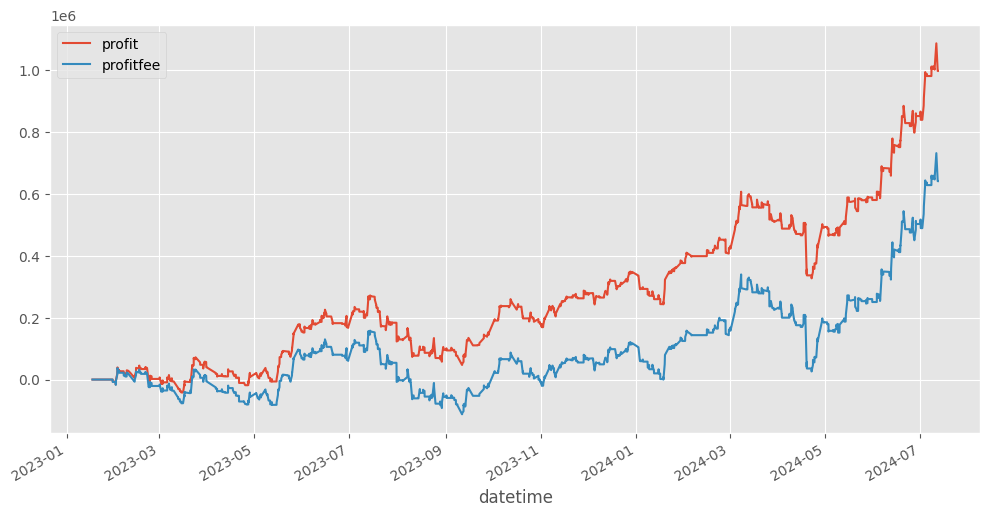

In [76]:
#建立存放資料的單位
BS = None
buy = []
sell = []
profit_list = [0]
profit_fee_list = [0]
profit_fee_list_realized = []

#開始交易流程
for i in range(len(df_arr)):

    #回測期間最後一天就跳出這個迴圈
    if i == len(df_arr)-1:
        break
    if i < 1:
        pass
    else:
      ## 進場邏輯
      entryLong = (df_arr[i,1] > df_arr[i-1,0])
      ### 結算日不進場
      entryCondition = date_arr[i] not in settlementDate

      ## 出場邏輯
      exitShort = (df_arr[i,1] < df_arr[i-1,0])
      ### 結算日時放到結算
      exitCondition = date_arr[i] in settlementDate

    #做多的狀態
    if BS == 'B':
      # 停利停損條件
      stopLoss = df_arr[i,1] <= df_arr[t,0] * (1-K)
      stopProfit = df_arr[i,1] >= df_arr[t,0] * (1+Kp)

#     if exitCondition == True:
#         print(f'{time_arr[i]}')

    #還沒進場不用計算損益
    if BS == None:
        profit_list.append(0)
        profit_fee_list.append(0)

        #確認進場&相關設定
        if entryLong and entryCondition:
          #更改狀態至做多
          BS = 'B'
          #紀錄進場時間
          t = i+1
          buy.append(t)
          print("Buy Price: {}, time: {}".format(df_arr[t,0], time_arr[t]))

    #進場開始計算未實現損益
    elif BS == 'B':

        profit = 200 * (df_arr[i+1,0] - df_arr[i,0])
        profit_list.append(profit)

        #近場條件達成，計算未實現損益-交易成本
        if exitShort or i == len(df_arr)-2 or exitCondition or stopLoss or stopProfit:
            pl_round = 200 * (df_arr[i+1,0] - df_arr[t,0])
            profit_fee = profit - feePaid*2
            profit_fee_list.append(profit_fee)

            #紀錄出場時間
            sell.append(i+1)

            #重置交易狀態
            BS = None
            print("Sell Price: {}, time: {}".format(df_arr[i+1,0], time_arr[i+1]))
            print("Trade completed")
            print()


            # Realized PnL
            profit_fee_realized = pl_round - feePaid*2
            profit_fee_list_realized.append(profit_fee_realized)

        #出場條件未達成，計算未實現損益
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)


equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=df_predict.index)
# print(equity)
equity.plot(grid=True, figsize=(12,6));

In [79]:
import seaborn as sns
import matplotlib.pyplot as py
plt.style.use('ggplot')

In [81]:
equity['equity'] = equity['profitfee'] + fund
equity['drawdown_percent'] = (equity['equity']/equity['equity'].cummax()) - 1
equity['drawdown'] = equity['equity'] - equity['equity'].cummax() #前n個元素的最大值
#print(profit_fee_list_realized)
profit = equity['profitfee'].iloc[-1]
ret = equity['equity'][-1]/equity['equity'][0] - 1
mdd = abs(equity['drawdown_percent'].min())
calmarRatio = ret / mdd
tradeTimes = len(buy)
winRate = len([i for i in profit_fee_list_realized if i > 0]) / len(profit_fee_list_realized)
profitFactor = sum([i for i in profit_fee_list_realized if i>0]) / abs(sum([i for i in profit_fee_list_realized if i<0]))

print('Profit : ',profit)
print('Return : ',ret)
print('Max DrawDown : ',mdd)
print('Caimar Ratio : ',calmarRatio)
print('Trade Times : ',tradeTimes)
print('Win Rate : ',winRate)
print('Profit Factor : ',profitFactor)

Profit :  641800.0
Return :  0.6417999999999999
Max DrawDown :  0.23417910447761192
Caimar Ratio :  2.7406373486297
Trade Times :  297
Win Rate :  0.3569023569023569
Profit Factor :  1.3124330639665076


<ipython-input-81-d31c005205ce>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret = equity['equity'][-1]/equity['equity'][0] - 1
